On rajoute les données meteo

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.tree import DecisionTreeRegressor

In [12]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [13]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [14]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [15]:
%run Regression_GAM_Gamma.py

# Val croisée

In [16]:
n_knots = 10
max_lag = 7
min_lag = 0

In [17]:
for curr_lag in range(min_lag, max_lag+1):
    for curr_depth in tqdm(range(1,51)):
        cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})

        cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
        for curr_split in range(9):
        
            # Entraintement
            curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
            curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        
            curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
            for code in liste_stations_debit:
                curr_train_X_mean[code] = 0
            curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
            curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_train_X_standard["Date"] = curr_train_X["Date"]
                #GAM
            spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
            curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                                   curr_train_X_standard, 
                                                                                   liste_stations_debit)
            curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, 
                                                          curr_train_X_standard[colonnes_meteo_stations]],
                                                         axis = 1)
                # Ajout AR
            colonnes_reg = colonnes_meteo_stations
            for i in range(curr_lag+1):
                variable = curr_train_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, variable], axis = 1)
                colonnes_reg = colonnes_reg + [code+"_"+str(i) for code in liste_stations_debit]
            curr_train_X_standard_residus = curr_train_X_standard_residus[(7+curr_lag):]
                # Train Tree
            model_tree = DecisionTreeRegressor(max_depth=curr_depth)
            model_tree.fit(X = curr_train_X_standard_residus[colonnes_reg],
                           y = curr_train_X_standard_residus[liste_stations_debit])
        
            # Predictions Standard
            curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
            curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
            liste_dates = curr_test_Y["Date"]
            curr_test_X_standard =fct_Standardize(curr_test_X, 
                                                  curr_train_X_mean, curr_train_X_std, 
                                                  liste_stations_debit + colonnes_meteo_stations)
            curr_test_X_standard["Date"] = curr_test_X["Date"].values
            curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit,
                                                                              curr_test_X_standard, 
                                                                              liste_stations_debit)
            curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, 
                                                      curr_test_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
                # Ajout variables AR
            for i in range(curr_lag+1):
                variable = curr_test_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, variable], axis = 1)
            curr_test_X_standard_residus = curr_test_X_standard_residus[(7+curr_lag):]
                # Predictions Tree
            predictions_test_Y_standard_residus = model_tree.predict(curr_test_X_standard_residus[colonnes_reg])
            predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
            predictions_test_Y_standard_residus["Date"] = curr_test_X_standard_residus["Date"].values
            # Filtre sur les dates
            resultat = pd.DataFrame()
            for curr_date in liste_dates:
                resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
            resultat = resultat.sort_values(by = "Date")
            predictions_test_Y_standard_residus = resultat.copy()
            # On rajoute la compo saisonnalité
            predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
            predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
            for code in liste_stations_debit:
                predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values
        
            # Score standard
            curr_test_Y_standard = fct_Standardize(curr_test_Y, 
                                                   curr_train_X_mean, curr_train_X_std, 
                                                   liste_stations_debit)
            curr_test_Y_standard["Date"] = curr_test_Y["Date"]
            curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
        
            # Score
            predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                                   curr_train_X_mean, curr_train_X_std, liste_stations_debit)
            predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
            curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
        cv_moyen_RMSE_standard = []
        cv_moyen_MAE_standard = []
        cv_moyen_R2_standard = []

        cv_moyen_RMSE = []
        cv_moyen_MAE = []
        cv_moyen_R2 = []

        for code in liste_stations_debit:
            score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE_standard.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE_standard.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2_standard.append(score_R2)
            score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2.append(score_R2)

        cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
        cv_scores_RMSE_standard.to_csv("../Data/GAMTreeAR/CV_RMSE_standard_" + str(curr_depth) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
        cv_scores_MAE_standard.to_csv("../Data/GAMTreeAR/CV_MAE_standard_" + str(curr_depth) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
        cv_scores_R2_standard.to_csv("../Data/GAMTreeAR/CV_R2_standard_" + str(curr_depth) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
        cv_scores_RMSE.to_csv("../Data/GAMTreeAR/CV_RMSE_depth_" + str(curr_depth) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE["Moyenne"] = cv_moyen_MAE
        cv_scores_MAE.to_csv("../Data/GAMTreeAR/CV_MAE_depth_" + str(curr_depth) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2["Moyenne"] = cv_moyen_R2
        cv_scores_R2.to_csv("../Data/GAMTreeAR/CV_R2_depth_" + str(curr_depth) + "_" + str(curr_lag) + ".csv",
                              index=False)
print("OK")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [30:36<00:00, 36.73s/it]

OK


## Selection

In [18]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


## Standard

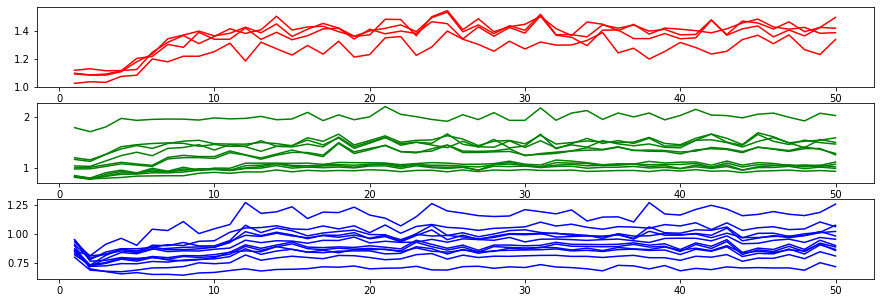

In [24]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMTreeAR/CV_RMSE_standard_" + str(curr_depth)+"_"+ str(curr_lag) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

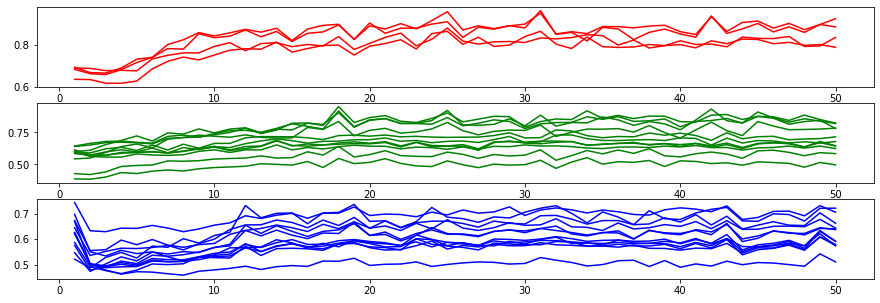

In [25]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMTreeAR/CV_MAE_standard_" + str(curr_depth) + "_"+str(curr_lag) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

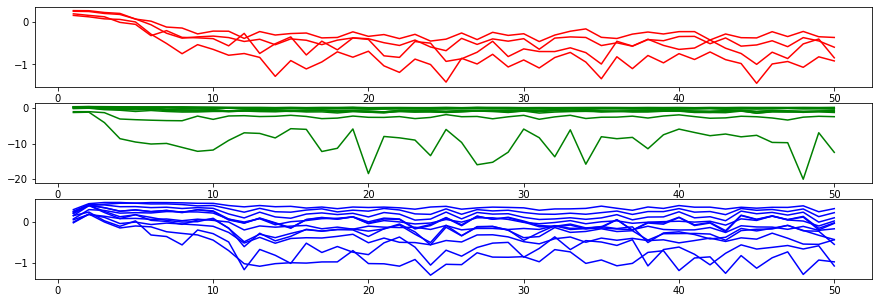

In [26]:
cv_moyen = pd.DataFrame()

for curr_depth in range(1,51):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMTreeAR/CV_R2_standard_" + str(curr_depth) +"_"+ str(curr_lag) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Max_depth"] = curr_depth
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Max_depth"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

## Moyen

In [27]:
cv_moyen = pd.DataFrame()
for curr_depth in range(1,51):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMTreeAR/CV_RMSE_standard_" + str(curr_depth) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Depth"] = curr_depth
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

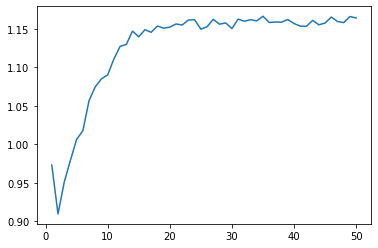

In [28]:
plt.plot(cv_moyen.groupby("Depth").mean().index, cv_moyen.groupby("Depth").mean()[liste_stations_debit].mean(axis = 1).values)

In [29]:
 cv_moyen.groupby("Depth").mean()[liste_stations_debit].mean(axis = 1)

Depth
1     0.973229
2     0.909798
3     0.950986
4     0.979498
5     1.006563
6     1.017849
7     1.056994
8     1.074897
9     1.085288
10    1.090365
11    1.111024
12    1.127426
13    1.129897
14    1.147217
15    1.139767
16    1.149047
17    1.145655
18    1.153763
19    1.151012
20    1.152336
21    1.156463
22    1.155146
23    1.161655
24    1.161949
25    1.149711
26    1.152932
27    1.162507
28    1.156193
29    1.157806
30    1.150534
31    1.162745
32    1.160023
33    1.162015
34    1.160489
35    1.166502
36    1.158420
37    1.158982
38    1.158851
39    1.162291
40    1.157055
41    1.153642
42    1.153526
43    1.161116
44    1.155344
45    1.157733
46    1.165507
47    1.159642
48    1.158280
49    1.166127
50    1.164253
dtype: float64

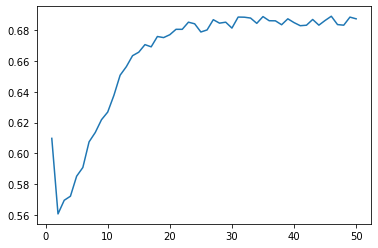

In [30]:
cv_moyen = pd.DataFrame()
for curr_depth in range(1,51):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMTreeAR/CV_MAE_standard_" + str(curr_depth) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Depth"] = curr_depth
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])
plt.plot(cv_moyen.groupby("Depth").mean().index, cv_moyen.groupby("Depth").mean()[liste_stations_debit].mean(axis = 1).values)

In [31]:
 cv_moyen.groupby("Depth").mean()[liste_stations_debit].mean(axis = 1)

Depth
1     0.609743
2     0.560576
3     0.569446
4     0.572093
5     0.585117
6     0.590796
7     0.607452
8     0.613572
9     0.621874
10    0.626837
11    0.637727
12    0.650825
13    0.656386
14    0.663538
15    0.665813
16    0.670741
17    0.669300
18    0.676023
19    0.675318
20    0.677194
21    0.680707
22    0.680697
23    0.685341
24    0.684299
25    0.678961
26    0.680299
27    0.686966
28    0.684720
29    0.685341
30    0.681502
31    0.688676
32    0.688591
33    0.688035
34    0.684586
35    0.688990
36    0.686291
37    0.686232
38    0.683683
39    0.687540
40    0.685070
41    0.683053
42    0.683368
43    0.687112
44    0.683410
45    0.686461
46    0.689211
47    0.683783
48    0.683387
49    0.688646
50    0.687529
dtype: float64

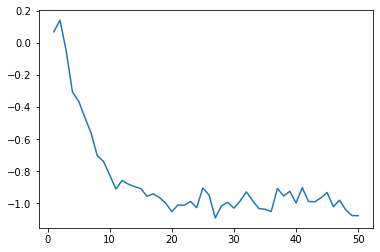

In [32]:
cv_moyen = pd.DataFrame()
for curr_depth in range(1,51):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMTreeAR/CV_R2_standard_" + str(curr_depth) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Depth"] = curr_depth
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])
plt.plot(cv_moyen.groupby("Depth").mean().index, cv_moyen.groupby("Depth").mean()[liste_stations_debit].mean(axis = 1).values)

In [33]:
 cv_moyen.groupby("Depth").mean()[liste_stations_debit].mean(axis = 1)

Depth
1     0.069418
2     0.141285
3    -0.050040
4    -0.305473
5    -0.362934
6    -0.464043
7    -0.561594
8    -0.702429
9    -0.737874
10   -0.823684
11   -0.910359
12   -0.856938
13   -0.879941
14   -0.895405
15   -0.907847
16   -0.955812
17   -0.940661
18   -0.963194
19   -0.998070
20   -1.051074
21   -1.009490
22   -1.012421
23   -0.987398
24   -1.026719
25   -0.903759
26   -0.948382
27   -1.090533
28   -1.015498
29   -0.993746
30   -1.029461
31   -0.985451
32   -0.928389
33   -0.982538
34   -1.031650
35   -1.036825
36   -1.050726
37   -0.907207
38   -0.953155
39   -0.924853
40   -0.997156
41   -0.901596
42   -0.987987
43   -0.990194
44   -0.966287
45   -0.932207
46   -1.020203
47   -0.979903
48   -1.040227
49   -1.075903
50   -1.076833
dtype: float64

# Test

In [34]:
depth = 5

In [35]:
# Donnees
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

mesures_test_X_standard =fct_Standardize(mesures_test_X, mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
mesures_test_Y_standard = fct_Standardize(mesures_test_Y, mesures_train_X_mean, mesures_train_X_std, 
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
liste_dates = mesures_test_Y["Date"]

In [36]:
# Entrainement
model_tree = DecisionTreeRegressor(max_depth=depth)
model_tree.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
               y = mesures_train_X_standard[liste_stations_debit])

DecisionTreeRegressor(max_depth=5)

In [37]:
# Predictions
predictions_test_Y_standard = model_tree.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values
    # Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [38]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

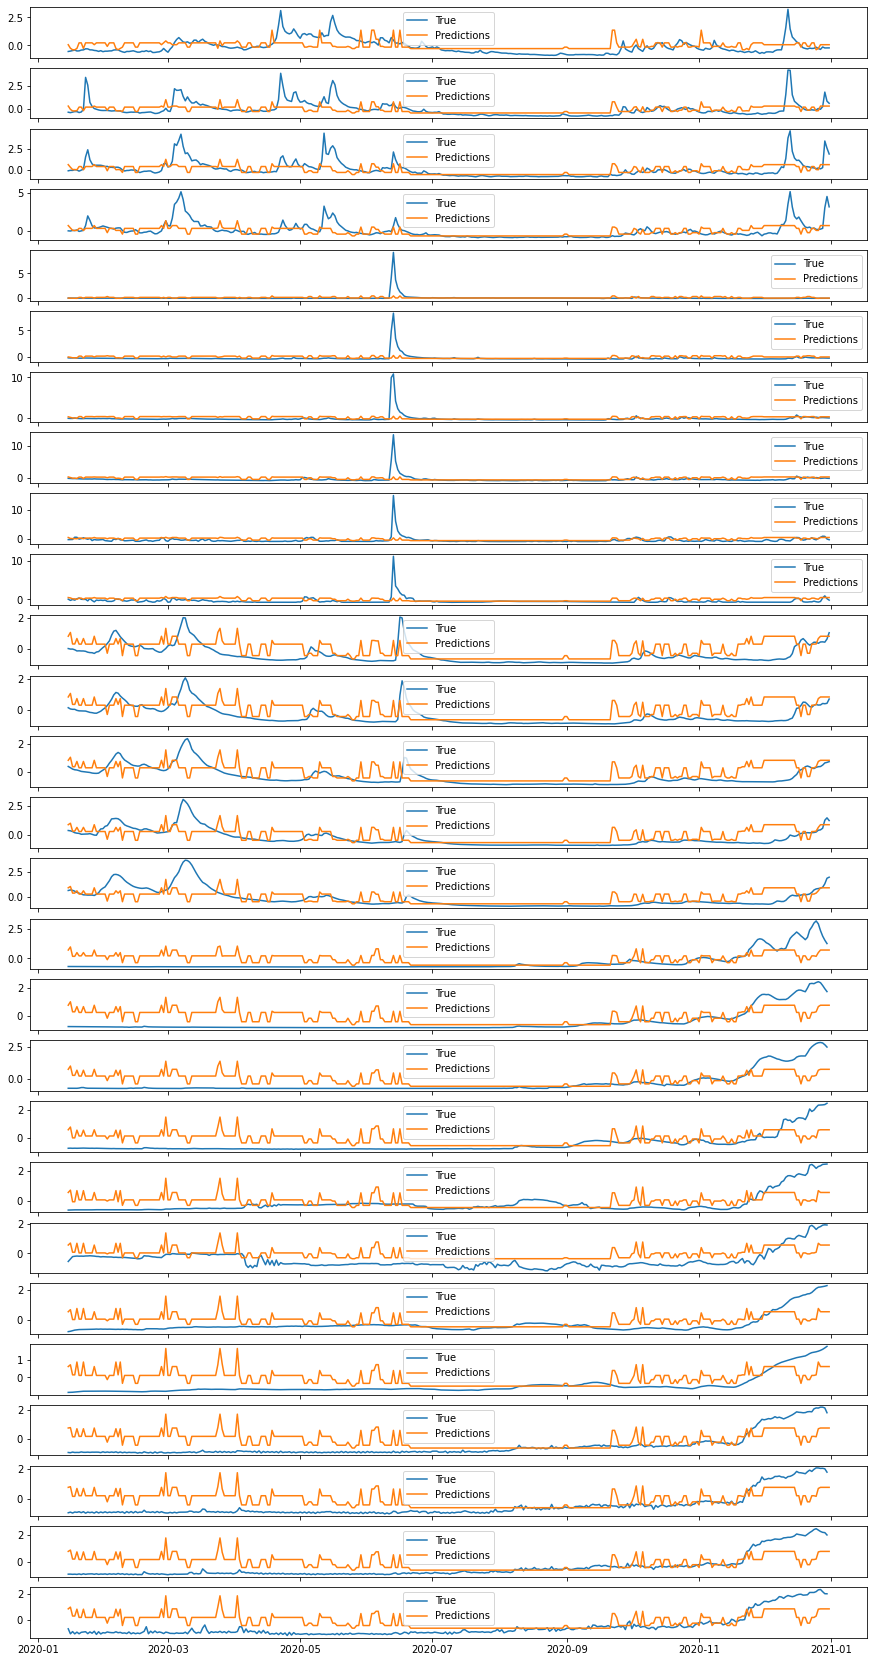

In [39]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

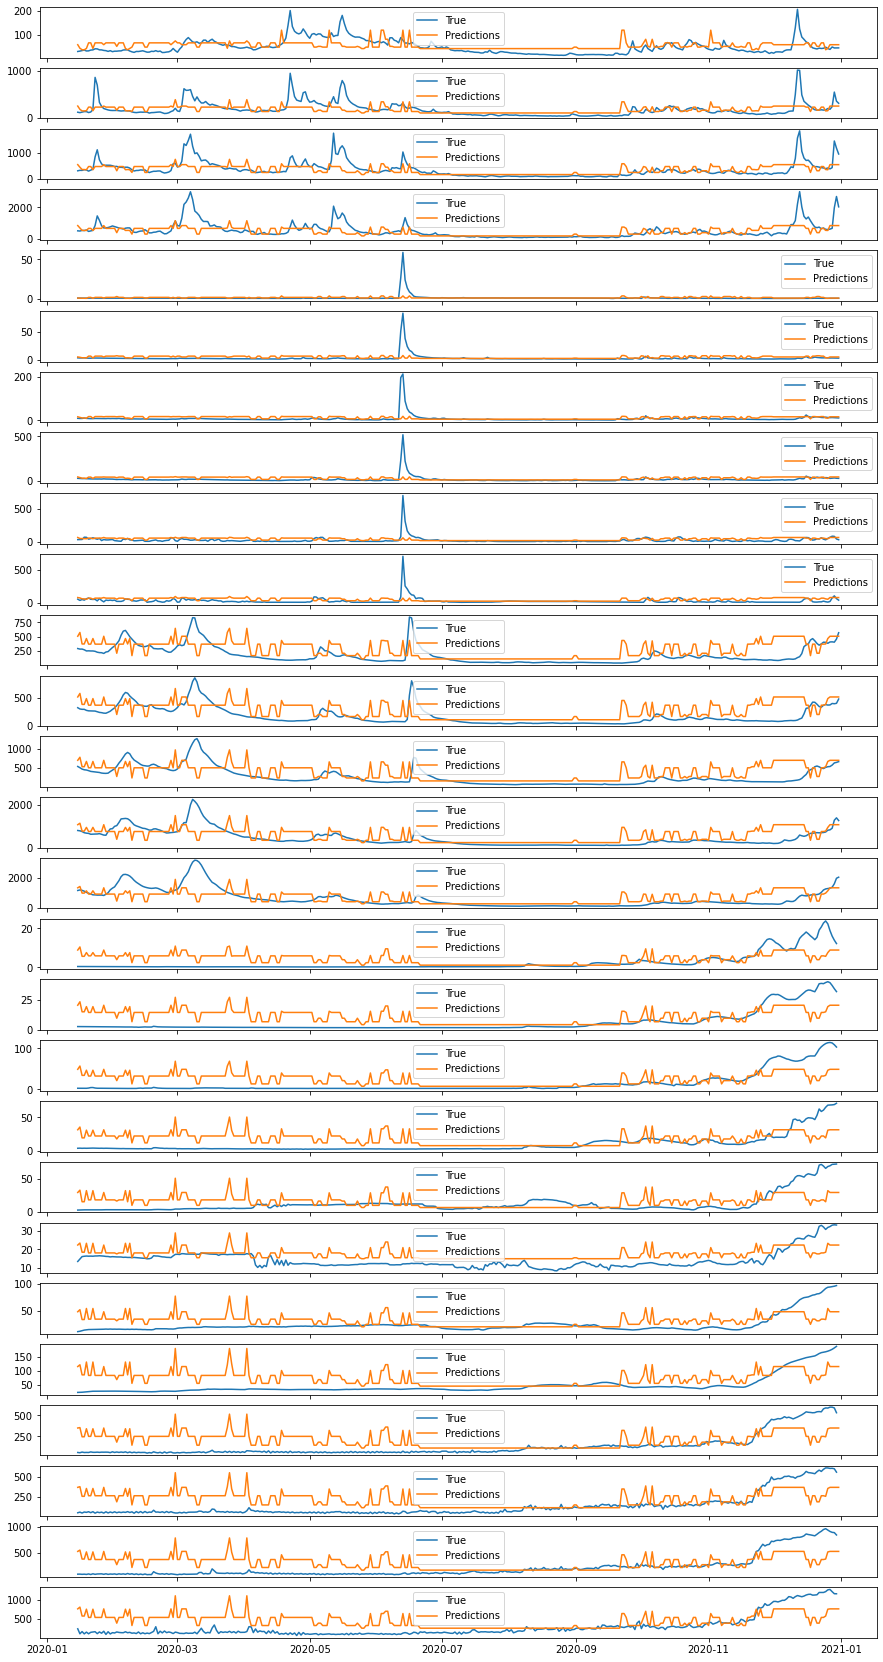

In [40]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y["Date"], mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y["Date"], predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [41]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard.to_csv("../Data/GAMTreeAR/Test_scores_standard.csv",
                   index = False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.666101,0.517257,-0.012073
1,O2620010,0.721887,0.474526,0.121628
2,O6140010,0.802411,0.513624,0.223084
3,O9000010,0.865257,0.524280,0.237071
4,K0030020,0.601068,0.175947,0.009094
5,K0100020,0.645300,0.323904,-0.080332
6,K0260020,0.934838,0.434803,-0.066724
7,K0550010,1.009384,0.549579,-0.086622
8,K0690010,1.079228,0.619373,-0.041527
9,K0910050,0.920685,0.594179,-0.132832


In [42]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.793032
MAE     0.491305
R2      0.007688
dtype: float64

In [43]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores.to_csv("../Data/GAMTreeAR/Test_scores.csv",
                   index = False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,30.921502,24.011940,-0.012073
1,O2620010,143.088190,94.057715,0.121628
2,O6140010,264.026258,169.003503,0.223084
3,O9000010,420.701128,254.913024,0.237071
4,K0030020,3.686096,1.079010,0.009094
5,K0100020,6.076035,3.049823,-0.080332
6,K0260020,17.317391,8.054496,-0.066724
7,K0550010,36.774340,20.022496,-0.086622
8,K0690010,48.280961,27.708621,-0.041527
9,K0910050,53.162658,34.309366,-0.132832
